In [1]:
%matplotlib inline
import io
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib
import matplotlib.pyplot as plt

module_path = 'https://tfhub.dev/deepmind/biggan-256/2'


tf.reset_default_graph()
print('Loading BigGAN module from:', module_path)
module = hub.Module(module_path)
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs)
print('Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.items()))
print('Output:', output)

Loading BigGAN module from: https://tfhub.dev/deepmind/biggan-256/2
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Inputs:
   y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  z: Tensor("z:0", shape=(?, 140), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)
Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


In [100]:
# Construct graph for BigGAN generator
with tf.variable_scope("inference"):
    # Sample random noise (z) and ImageNet label (y) inputs.
    batch_size = 1
    truncation = 0.2  # scalar truncation value in [0.02, 1.0]
    z_label = truncation * tf.random.truncated_normal([batch_size, 140])  # noise sample
    # y_index = tf.random.uniform([batch_size], maxval=1000, dtype=tf.int32)
    y_index = tf.ones(batch_size, dtype=tf.int32) * 281
    y = tf.one_hot(y_index, 1000)  # one-hot ImageNet label

    # Call BigGAN on a dict of the inputs to generate a batch of images with shape
    # [8, 256, 256, 3] and range [-1, 1].
    samples_label = module(dict(y=y, z=z_label, truncation=truncation))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [101]:
# Construct graph for noise optimization
with tf.variable_scope("optimization"):
    # Sample random noise (z) and ImageNet label (y) inputs.
    batch_size = 1
    truncation = 0.5  # scalar truncation value in [0.02, 1.0]
    z = tf.Variable(truncation * tf.random.truncated_normal([batch_size, 140]), name="z")  # noise to be optimized
    x = tf.placeholder(tf.float32, (batch_size, 256, 256, 3), name='img')  # image to reconstruct
    # y_index = tf.random.uniform([batch_size], maxval=1000, dtype=tf.int32)
    y_index = tf.ones(batch_size, dtype=tf.int32) * 281
    y = tf.one_hot(y_index, 1000)  # one-hot ImageNet label

    # Call BigGAN on a dict of the inputs to generate a batch of images with shape
    # [8, 256, 256, 3] and range [-1, 1].
    samples = module(dict(y=y, z=z, truncation=truncation))
    loss = tf.losses.mean_squared_error(x, samples)
    train_op = tf.contrib.opt.ScipyOptimizerInterface(loss, method="L-BFGS-B", options={'maxiter': 500})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [102]:
# Initialize variables
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

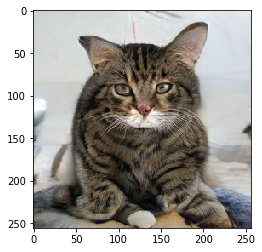

In [173]:
# Sample a random image from BigGAN
# x_label, latent_code_label = sess.run([samples_label, z_label])
x_label = [np.array(PIL.Image.open('/afs/csail.mit.edu/u/y/yenchenlin/Workspace/biggan/cat.png'))]
x_label[0] = x_label[0]/255.0*2.0 - 1
f, axarr = plt.subplots(1, 1, figsize=(4,4))
axarr.imshow((np.asarray((x_label[0] + 1)/2.0*255.0, dtype=np.uint8)))

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 0.010515
  Number of iterations: 500
  Number of functions evaluations: 515


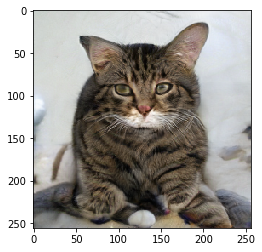

In [175]:
# Run L-BFGS to get latent code that can reconstruct image from BigGAN
train_op.minimize(sess, feed_dict={x: x_label})
img, latent_code = sess.run([samples, z])
f, axarr = plt.subplots(1, 1, figsize=(4,4))
axarr.imshow((np.asarray((img[0] + 1)/2.0*255.0, dtype=np.uint8)))